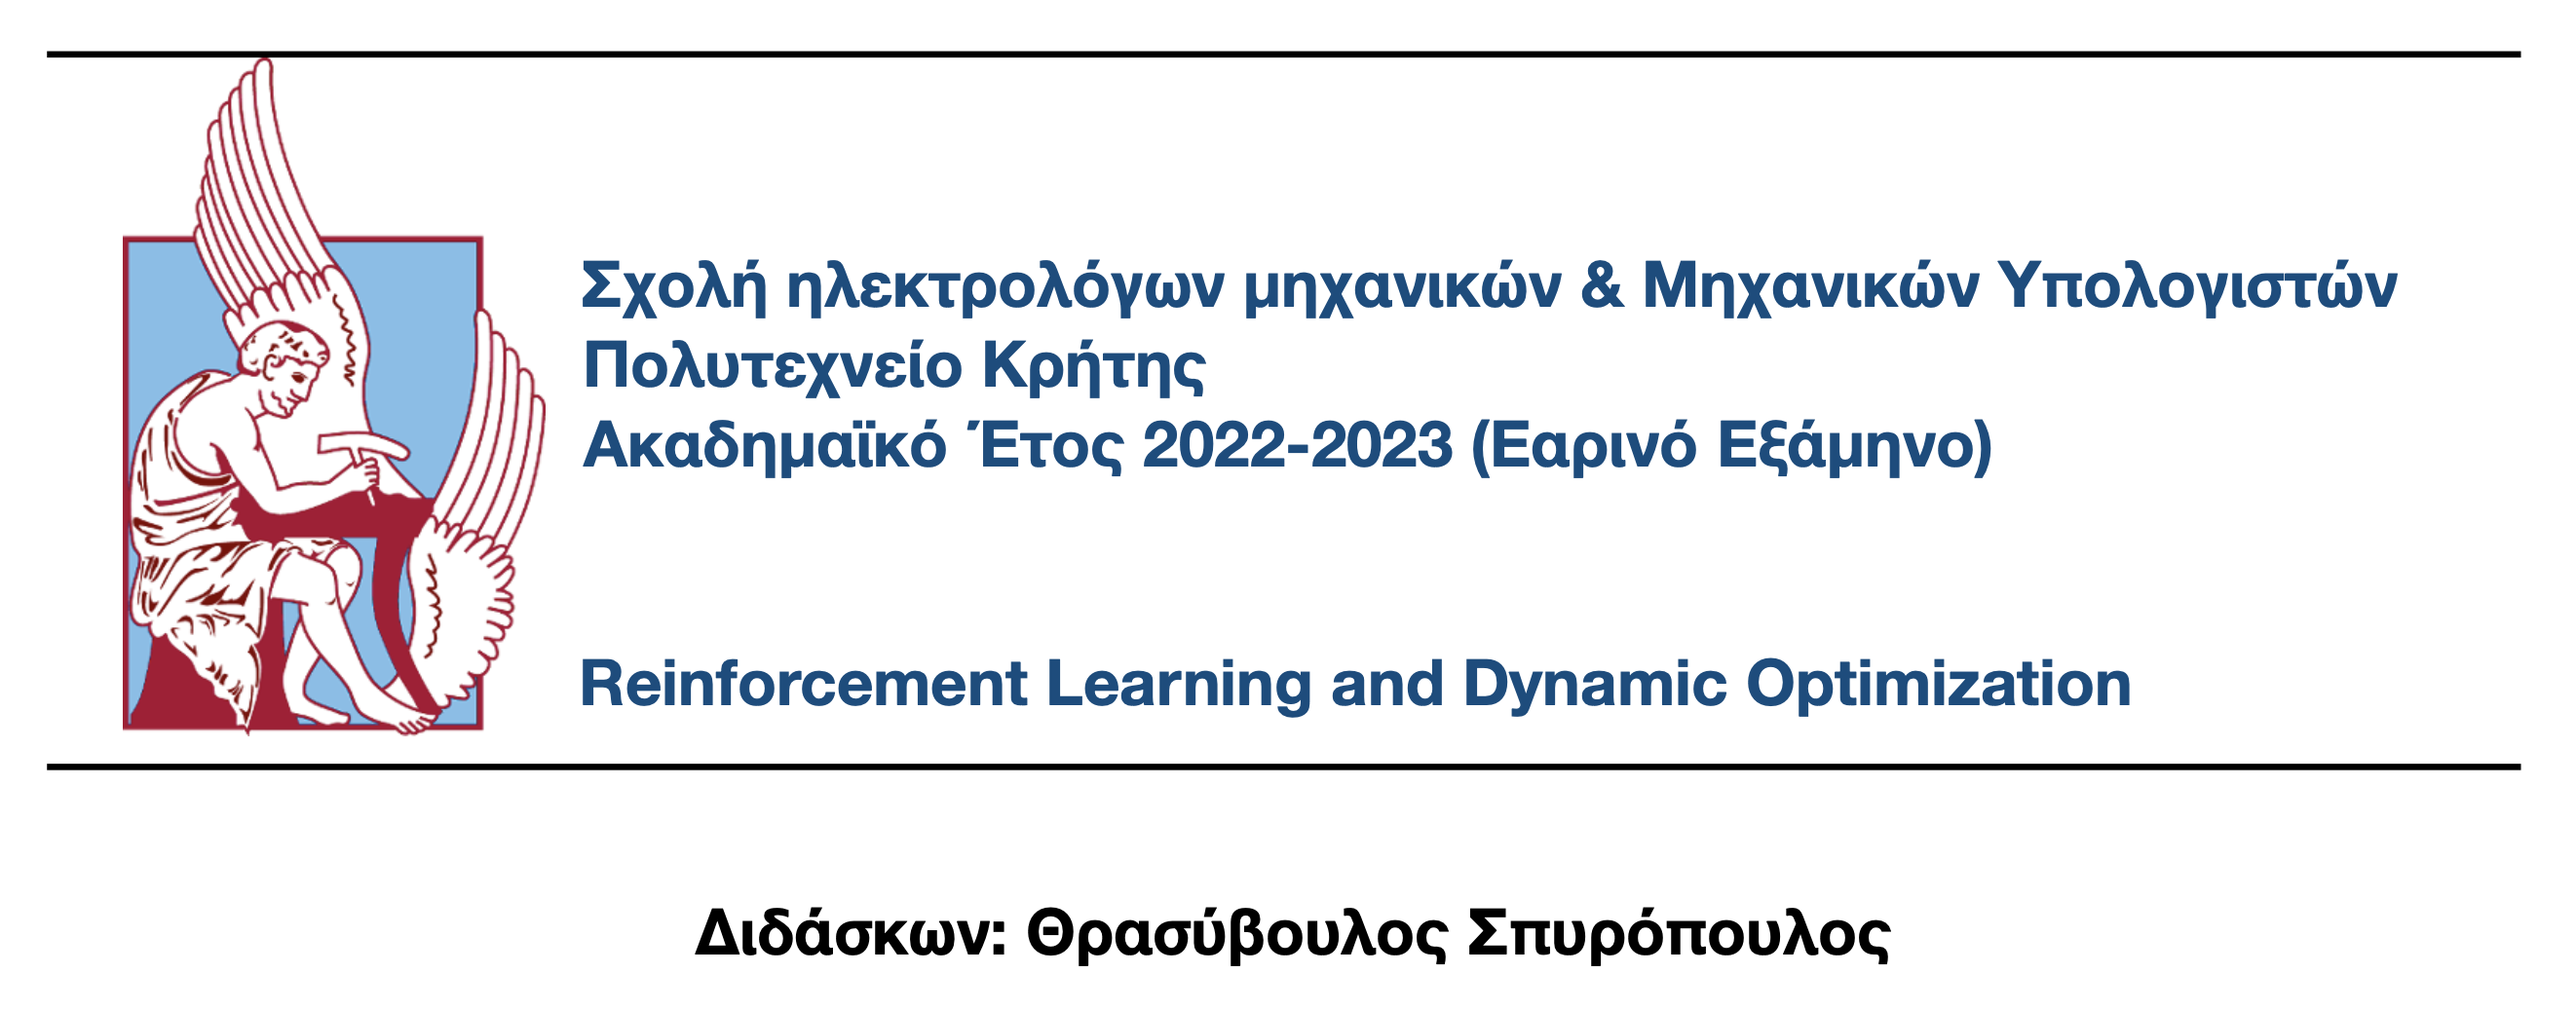


# **Poker Playing Agent Project**
### Στοιχεία Φοιτητών Ομάδας  
Φοιτητής 1    
Αριθμός Μητρώου: 2019030033   
Ονοματεπώνυμο: Γεώργιος Μιχαήλ Σιάτρας    
Φοιτητής 2    
Αριθμός Μητρώου: 2015030002  
Ονοματεπώνυμο: Τασιόπουλος Ιωάννης


# **Importing our project**

In [ ]:
!git clone https://github.com/gsiatras/rlcard.git
!pip install /content/rlcard --upgrade

Cloning into 'rlcard'...
remote: Enumerating objects: 7434, done.
remote: Counting objects: 100% (785/785), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 7434 (delta 589), reused 682 (delta 521), pack-reused 6649
Receiving objects: 100% (7434/7434), 8.25 MiB | 11.98 MiB/s, done.
Resolving deltas: 100% (5116/5116), done.
Processing ./rlcard
  Preparing metadata (setup.py) ... done
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=390496 sha256=2bcdbc10d7b1659d3ecbd5b9cda3d1ddeed083dc786a4e2d1fc742481b100f97
  Stored in directory: /tmp/pip-ephem-wheel-cache-vyngaquh/wheels/f0/47/5f/a605ab09c4ed2516fc5cad79a39f79960c49125902511d8227
Successfully built rlcard


In [ ]:
import rlcard
from rlcard.agents import *

❗ if the import above doesnt work then the examples below will not run!

# **ENVIROMENT**

## **Enviroment description**  


---
Location: rlcard/rlcard/games/newlimitholdem  && envs/newlimitholdem    
also one change in rlcard/rlcard/utils/utils where we added the method init_20_deck().
# Brief description:  
Following the standards of the other rlcard games, specifically
limit holdem  
✅2 players  
✅2 betting rounds    
✅Deck: 10,J,Q,K,1 all suits  
✅1 Hand card for each player    
✅2 Community cards dealt in second round     
✅Starting bet: 1 token
### Betting round possible sequances:   
▶ Round 1: Each player sees their own card, but the 2 table cards
are still unknown; Player 1 can check or bet 1 token.

In case of check: Player 2 can also check, or raise one token. In the latter case, Player 1 can fold or bet 1 token too.

In case of betting: Player 2 can fold, bet 1 token also, or raise 1 token (i..e bet a total of 2). In the latter case, player 1 can fold, or bet that extra token (this is not a "re-raise", player 1 just "meets" the raise of player 2)

▶ Round 2: Both table cards are revealed. Another betting round follows with the same rules as Round 1.
### Winning rules
🥇 3 of a kind    
🥈 1 pair: highest pair wins (with order as usual: 1,K,Q,J,10). In case of same pair (but different suit), highest 3rd card wins.   
🥉 highest card   
ignore "flush" (3 of same suit)



### States


---


To describe each state our agents can be in a game we use an observation array: **obs[32]**.    
Our states are defined by:  
⚫Our agents hand card( first 5 positions of array (obs[0]=1 ➡ A etc))    
⚫Public cards if revealed( next 10 positions(5 for each card))    
⚫Our bet(chips) (next 6 positions)    
⚫Opponent's bet(chips)(next 6 positions)  
⚫Legal moves of state(next 4 positions: 0:call|1:raise|2:fold|3:check)      
⚫Our starting position(last position)


**In total we have a maximun state space of 1225 states**    


---



```
# public_cards = state['public_cards']
        hand = state['hand']

        obs = np.zeros(32)
        idx = [self.card2index[card] for card in hand]
        obs[idx] = 1
        idx2 = []
        for j, card in enumerate(public_cards):
            idx2 = [(self.card2index[card] + 5*j)]
            obs[idx2] = 1
        obs[state['my_chips'] + 15] = 1
        obs[sum(state['all_chips']) - state['my_chips'] + 21] = 1
        for i in legal_actions:
            idx3 = [i + 27]
            obs[idx3] = 1
        obs[31] = state['first']
```


The code above can be found in env/newlimitholdem/_extract_state(self, state)

### Possible Actions


---
◼ Call  (answer the bet of the opponent +1 chip)  
◼ Raise (Raise the bet +1 chip)      
◼ Fold  (Fold and lose)   
◼ Check (Keep the current bet)    

❗ Not all actions are available at every state:  


```
# full_actions = ['call', 'raise', 'fold', 'check']

        # If the number of raises already reaches the maximum number raises, we can not raise any more
        if self.action_taken >= self.allowed_action_num:
            full_actions.remove('raise')

        # If the current chips are less than that of the highest one in the round, we can not check
        if self.raised[self.game_pointer] < max(self.raised):
            full_actions.remove('check')

        # If the current player has put in the chips that are more than others, we can not call
        if self.raised[self.game_pointer] == max(self.raised):
            full_actions.remove('call')

        # and if he has put more chips he cannot fold
        if self.raised[self.game_pointer] == self.raised[(self.game_pointer + 1) % self.num_players]:
            full_actions.remove('fold')
```


Code above can be found in rlcard/newlimitholdem/round.


### Agents


---
🔵 Random agent: Random decision between legal actions.  
🔵 Threshold agent1: In round 1 it will always bet/raise with a K or Ace.
In round 2 it always raise.   
🔵 Threshold agent2: In round 1 it will always bet/raise with a K or Ace. In round 2 it will always bet/raise with any pair and three of a kind.

## Example of playing against Threshold agent2:

In [ ]:
import os

#import args as args

import rlcard
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.agents import RandomAgent, ThresholdAgent, ThresholdAgent2
from rlcard.utils.utils import print_card

# Make environment
env = rlcard.make('new-limit-holdem')
human_agent = HumanAgent(env.num_actions)
# Init agent:
agent_0 = ThresholdAgent2(num_actions=env.num_actions)

# hard code the agen you want to play against (pi_agent, ql_agent, sarsa_agent)
env.set_agents([
    human_agent,
    agent_0,
])

print(">>New Limit Hold'em random agent")

while (True):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action

    if len(trajectories[0]) != 0:
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            """
            if action_record[-i][0] == state['current_player']:
                break
            """
            _action_list.insert(0, action_record[-i])
        for pair in _action_list:
            print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('=============     Random Agent    ============')
    print_card(env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    # print(trajectories[0])
    # print("=========================================================================================================")
    # print(trajectories[1])
    input("Press any key to continue...")


>>New Limit Hold'em random agent
>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐
│10       │
│         │
│         │
│    ♦    │
│         │
│         │
│       01│
└─────────┘
===============     Chips      ===============
Yours:   +
++
=========== Actions You Can Choose ===========
0: raise, 1: check



KeyboardInterrupt: ignored

# **Policy Iteration**

## Brief description

---
🟢 Starting we run games with all possible card combinations(hand/public/opponent) and starting possitions.    
🟢 While we run each game we initialize a random policy if it is the first time we encounter each state(**action_probs()**). Thats how we initialize our state space and our initial random policy.     
🟢 In the final state we return the reward of the game.  
🟢 At a random state of our agent:    
▶ We take every possible action and compute its Qvalue     
▶ We alter the policy based on those Qvalues    
▶ We compute our Vstate based on our ***OLD*** policy and we return it to be used as a Qvalue of the previous state    
 ▶ We loop this until our policy is stable.   
🟢 At our opponent's turn we basicly run all possible actions and on all possible combination of cards and we return the Qvalue of the action taken below.

## Detailed description

### A more detailed description of our algorithm
---    
🟢**Arguments**:    
▶**policy**: The dictionary where we store our policy, we use as key a tupple(obs[32], card, probability) or tupple(obs[32], card, public_card, probability) and the value is leads to is numpy array contain the probability of every action (eg [0 0.4 0 0.6]). Obs[32] is the array that describes every observable state. More about the tupple following.    
▶**agent_id**: this indicates the starting possition of our agent in a game   
▶**flag2**: flag that indicates that we are in the first betting round. More to follow.   
▶**gamma factor**: no immediate rewards so we used 1.
```
# self.public_card_prob = None  # prob of having this set of public cards
        self.hand_card_prob = None    # prob of having this set of hand cards
        self.gamma = g                # gamma value
        self.agent_id = 0             # starting possition of agent
        self.rank_list = ['A', 'T', 'J', 'Q', 'K']
        self.use_raw = False
        self.env = env
        self.model_path = model_path


        # A policy is a dict state_str -> action probabilities
        self.policy = collections.defaultdict(list)
        self.iteration = 0
        self.flag2 = 0               # flag that indicates weather we are in round 0 or 1
        self.rank = None
        self.public_ranks = None
```


🟢 **Initial loop**:    
 We start with a loop that breaks when we dont have any changes in our policy. To do that we save the previous policy and we proceed to evaluate_policy(). If we find no changes we 'remake' the policy, we will explain afterwards what that means.

```
# while True:
            #k += 1
            self.iteration += 1
            print('-----------------------------------------------------------------------')
            print('Current iteration: %d' % self.iteration)
            old_policy = self.policy.copy()
            self.evaluate_policy()
            if self.compare_policys(old_policy, self.policy):
                break
            if self.iteration == 10:
                break
        print('=============================================================================')
        print('Optimal policy found: State space length: %d after %d iterations' % (len(self.policy), self.iteration))
        self.remake_policy()
```
🟢 **Evaluate policy**:   
 To run through all the state space we run games for all possible card combinations (hand card-opponent card-public cards) and all possible starting possitions and all the possible actions for every state.   
🚫 The main problem we encountered when running a more traditional policy iteration algorithm was that each action leads to a large number of possible states, this is because we have to take into account all the possible cards that the opponent could have and that could lead to multiple rewards. For example we take an action in the first round and continue traversing the game, we have different possible states for every possible combination of public cards. This is something we encounter in every state and was causing a very slow convergence.   
🔸 The solution we came up to is the following: We run games with all the possible card combinations initialized from the start and when we encounter a state and we want to save the policy for the state we have as a key a tupple that contains the obs array and the probability of getting those card combination. Then we remake the policy based on those probabilities (we will explain afterwards).


```
# def evaluate_policy(self):
        self.find_agent()
        suit = 'S'
        Vtotal = 0
        for rank1 in self.rank_list:
            for rank2 in self.rank_list:
                for rank3 in self.rank_list:
                    for rank4 in self.rank_list:
                        self.env.reset(self.agent_id, self.agent_id, Card(suit, rank1), Card(suit, rank2),
                                       Card(suit, rank3), Card(suit, rank4))
                        self.rank = rank4
                        self.public_ranks = (rank2, rank3)
                        self.get_public_card_probs(rank1, rank2, rank3, rank4)
                        Vtotal += self.traverse_tree()
        player = (self.agent_id + 1) % self.env.num_players
        for rank1 in self.rank_list:
            for rank2 in self.rank_list:
                for rank3 in self.rank_list:
                    for rank4 in self.rank_list:
                        self.env.reset(player, self.agent_id, Card(suit, rank1), Card(suit, rank2),
                                       Card(suit, rank3), Card(suit, rank4))
                        self.rank = rank4
                        self.public_ranks = (rank2, rank3)
                        self.get_public_card_probs(rank1, rank2, rank3, rank4)
                        Vtotal += self.traverse_tree()
        print('Total value: %d' % Vtotal)
        return Vtotal
```
🟢 **Traverse_tree():**     
This is the method responsible for running the games and changing the policy. It uses a clasic dynamic programming approach to reach every possible state until the ending state when we get our reward/chips won or lost.
**3 possible situations**:    
▶**End game**:    
 we reached the end of the game so we return the chips won/lost as reward.     


```
# if self.env.is_over():
            chips = self.env.get_payoffs()
            return chips[self.agent_id]
```


▶**Other agent turn**:      
We take into account all possible actions. What this basicly does is return the expected value of value of the next states that an action of our agent could bring:
\begin{align}
        Q(s,a) = \sum_{s'}prob(s,a,s')V(s').
    \end{align}
Before that we call round_zero() to check if we are in the first round (different possible states).   


```
# # compute the q of previous state
        if not current_player == self.agent_id:
            obs, legal_actions = self.get_state(current_player)
            state = self.env.get_state(current_player)
            action_probs = self.env.agents[current_player].get_action_probs(state, self.env.num_actions)
            Vstate = 0
            for action in legal_actions:
                prob = action_probs[action]
                if prob == 0:
                    continue
                # Keep traversing the child state
                self.env.step(action)
                v = self.traverse_tree()
                Vstate += v * prob
                self.env.step_back()
            return Vstate*self.gamma
```
▶**Our agent turn**:    
For our agent we first take our current policy for this state with action_probs(more to follow). Then we take every action and store the Qvalue in the quality list. Then we improve the policy based on the new Qvalues. Then we return \begin{align}
        V(s) = \sum_{a}prob(a|old policy)V(s').
    \end{align}


```
# if current_player == self.agent_id:
            quality = {}
            Vstate = 0
            obs, legal_actions = self.get_state(current_player)
            # if first time we encounter state initialize qualities
            action_probs = self.action_probs(obs, legal_actions, self.policy)

            for action in legal_actions:
                prob = action_probs[action]
                # Keep traversing the child state
                self.env.step(action)
                v = self.traverse_tree()
                self.env.step_back()

                quality[action] = v  # Qvalue
                Vstate += v*prob

            ''' alter policy by choosing the action with the max value'''
            self.round_zero()
            self.improve_policy(obs, quality)

        return Vstate * self.gamma
```
🟢**action_probs()**:   
This method basicly initializes a random policy for all the new states found( first iteration of the algorithm) or return the current policy-action probabilities of the state.



```
# def action_probs(self, obs, legal_actions, policy, eval=False):
      if eval:
            if obs in self.policy:
                return self.policy[obs]
            else:
                print('sok')

        if self.flag2 == 0:
            obs1 = (obs, self.hand_card_prob, self.rank)
        elif self.flag2 == 1:
            obs1 = (obs, self.public_card_prob, self.rank, self.public_ranks)
        # if new state initialize policy
        if obs not in policy.keys() and obs1 not in policy.keys():
            best_action = random.choice(legal_actions)
            # best_action = np.argmax(tactions)
            action_probs = np.array([0 for action in range(self.env.num_actions)])
            action_probs[best_action] = 1
            self.policy[obs1] = action_probs
        elif obs not in policy.keys():
            action_probs = policy[obs1].copy()
        else:
            print('1')
            action_probs = policy[obs].copy()
        action_probs = remove_illegal(action_probs, legal_actions)
        return action_probs
```



🟢**improve_policy()**:     
This method is called when we want to improve the policy. What wee do is take the Q values of the state and turn them into probabilities with softmax(q) (for example [-inf 1 -inf 1] => [0 0.5 0 0.5]).


```
# def improve_policy(self, obs, quality):
       if current_player == self.agent_id:
            quality = {}
            Vstate = 0
            obs, legal_actions = self.get_state(current_player)
            # if first time we encounter state initialize qualities
            action_probs = self.action_probs(obs, legal_actions, self.policy)

            for action in legal_actions:
                prob = action_probs[action]
                # Keep traversing the child state
                self.env.step(action)
                v = self.traverse_tree()
                self.env.step_back()

                quality[action] = v  # Qvalue
                Vstate += v*prob

            ''' alter policy by choosing the action with the max value'''
            self.round_zero()
            self.improve_policy(obs, quality)

        return Vstate * self.gamma
```

🟢**get_public_card_probs()**:    
This method returns the probability of having a specific combination of cards.      

🟢**compare_policys()**:    
This method checks if our old policy is the same as our new one.    
It starts by checking the policy keys and if we have the same number of keys we check each of the state policys.      
🟢**remake_policy()**:     
Reaching this part of the algorithm we have state space much larger than the actual one as it also consists from the different opponent possible cards and also for the first round it consists from the different public cards that could be unvealed. This method makes the **average policy** based on the probabilities we stored previously in the tupple and creates a policy with keys of the dictionary only the **obs[32]** array, so our new policy is based on observable states of the enviroment.    
For example for an observable state in the first round of the the initial policy we have 125 different policies! That is because that each of the action could bring diffrent rewards depending on the public cards and the opponent hand which are still unknown or generally unknown. However, we have modeled the probability of each and we can produce an **average policy** for the observable state.

```
#  def remake_policy(self):
        new_policy = collections.defaultdict(list)
        old_policy = self.policy

        for key1 in old_policy:
            if isinstance(key1, tuple):
                obs1 = key1[0]
                if obs1 in new_policy:
                    continue
                same_obs_values = []
                probs = np.array([])
                for key2 in old_policy:
                    if isinstance(key2, tuple):
                        obs2 = key2[0]
                        if obs1 == obs2:
                            same_obs_values.append(old_policy[key2])
                            probs = np.append(probs, key2[1])
                if same_obs_values:
                    new_policy = self._policy_sum(new_policy, same_obs_values, obs1, probs)
                else:
                    print('10')

        self.policy = new_policy

```
All the code parts listed above can be found in **rlcard/agents/pi_agent** with detailed commenting.





## Experiments

---



### Policy Iteration VS Random Agent


---
We train our agent having a known opponent(Random) and then we evaluate for 3000
games getting the average reward per game as a result. We do 5 sets(episodes) of evaluating just to make sure we have a stable result and we plot just to be easier to see.


-----------------------------------------------------------------------
Current iteration: 1
Total value: 162
Dif number of policy keys
-----------------------------------------------------------------------
Current iteration: 2
Total value: 955
Changes in policy: 3650
-----------------------------------------------------------------------
Current iteration: 3
Total value: 1014
Changes in policy: 800
-----------------------------------------------------------------------
Current iteration: 4
Total value: 1017
Optimal policy found: State space length: 10725 after 4 iterations

----------------------------------------
  episode      |  0
  reward       |  1.1513333333333333
----------------------------------------

----------------------------------------
  episode      |  1
  reward       |  1.1486666666666667
----------------------------------------

----------------------------------------
  episode      |  2
  reward       |  1.138
----------------------------------------

----------

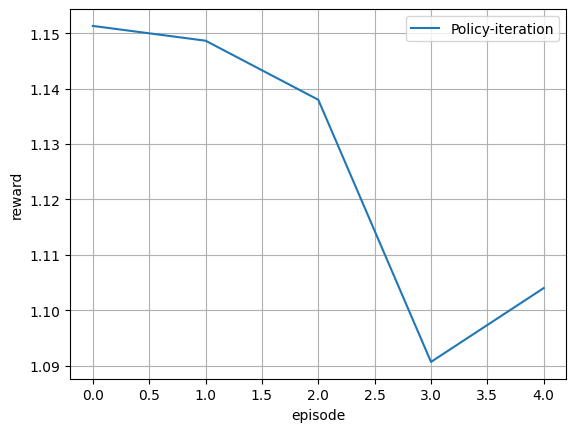

In [ ]:
''' An example of solving New Hold'em with policy iteration
'''
import os
import argparse

import rlcard
from rlcard.agents import (
    RandomAgent, PIAgent
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = PIAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_pi_result/',
            'pi_model',
        ),
    )


    # Evaluate PI
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])


    # Start training
    with Logger('experiments/new_limit_holdem_pi_result/') as logger:
        # Evaluate the performance.
        agent.train()
        agent.save()
        for episode in range(5):
            logger.log_performance(
                episode,
                tournament(
                    eval_env,
                    3000
                )[0]
            )
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Policy-iteration')

if __name__ == '__main__':
    train()


### ⭕ **Results**

---



▶ At each iteration we print the total value earned for running the old policy for the sum of different games and also the changes in policy.   
▶ As we can see we win **1.1 - 1.2 chips** per game running our mdp model. This seems to be a good result as the maximum bet is only 5 chips. This is also the best reward we get running the Qlearning algorithm (more afterwards) so can say that we have an optimal policy.  
▶ We also get the total 'mixed' state space which is 10725 states. This includes opponents possible cards and also possible public cards. **It is not the observable one.**



### Policy Iteration VS Threshold Agent 1


---
We train our agent having a known opponent(Threshold1) and then we evaluate for 3000
games getting the average reward per game as a result. We do 5 sets(episodes) of evaluating just to make sure we have a stable result and we plot just to be easier to see.

-----------------------------------------------------------------------
Current iteration: 1
Total value: -783
Dif number of policy keys
-----------------------------------------------------------------------
Current iteration: 2
Total value: 494
Changes in policy: 3404
-----------------------------------------------------------------------
Current iteration: 3
Total value: 642
Changes in policy: 935
-----------------------------------------------------------------------
Current iteration: 4
Total value: 651
Optimal policy found: State space length: 8005 after 4 iterations

----------------------------------------
  episode      |  0
  reward       |  0.10033333333333333
----------------------------------------

----------------------------------------
  episode      |  1
  reward       |  0.09933333333333333
----------------------------------------

----------------------------------------
  episode      |  2
  reward       |  0.14166666666666666
--------------------------------------

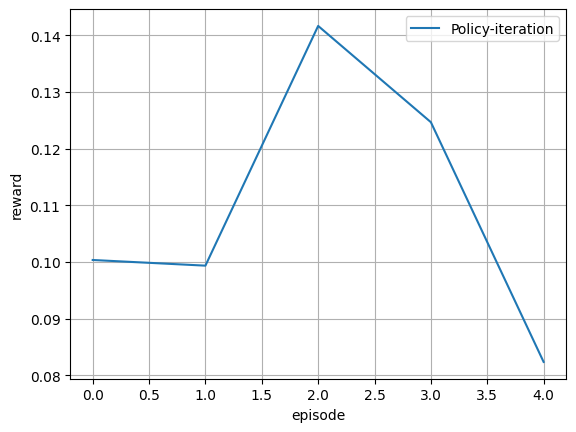

In [ ]:
''' An example of solving New Hold'em with policy iteration
'''
import os
import argparse

import rlcard
from rlcard.agents import (
    ThresholdAgent, PIAgent
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = PIAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_pi_result/',
            'pi_model',
        ),
    )


    # Evaluate PI
    eval_env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])


    # Start training
    with Logger('experiments/new_limit_holdem_pi_result/') as logger:
        # Evaluate the performance.
        agent.train()
        agent.save()
        for episode in range(5):
            logger.log_performance(
                episode,
                tournament(
                    eval_env,
                    3000
                )[0]
            )
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Policy-iteration')

if __name__ == '__main__':
    train()


### ⭕ **Results**

▶ At each iteration we print the total value earned for running the old policy for the sum of different games and also the changes in policy.   
▶ As we can see we win **0.1-0.2 chips** per game running our mdp model. It seems reasonable to have such a low chips won per game as the game rules as very simple and the rule based model can produce a good policy. However this doesnt seem to be the optimal policy but a sub-optimal one. Afterwards we will see that the Qlearning agents produce a policy that achieves better results.    
▶ A possible explanation of our policy not being optimal is that our algorithm takes the average policy between multiple possible card combinations that could come based on the probability of getting those cards. However different card combination could result of huge differences in the policy and getting the average of them could be a non optimal solution.  
▶ We also get the total 'mixed' state space which is 8005 states. Less than random because Threshold agent never visits some states(0 probability of making this move) so we skip this move to improve convergence speed


### Policy Iteration VS Threshold Agent 2

---


We train our agent having a known opponent(Threshold2) and then we evaluate for 3000 games getting the average reward per game as a result. We do 5 sets(episodes) of evaluating just to make sure we have a stable result and we plot just to be easier to see.

-----------------------------------------------------------------------
Current iteration: 1
Total value: -524
Dif number of policy keys
-----------------------------------------------------------------------
Current iteration: 2
Total value: 644
Changes in policy: 3049
-----------------------------------------------------------------------
Current iteration: 3
Total value: 749
Changes in policy: 834
-----------------------------------------------------------------------
Current iteration: 4
Total value: 755
Optimal policy found: State space length: 7141 after 4 iterations

----------------------------------------
  episode      |  0
  reward       |  0.136
----------------------------------------

----------------------------------------
  episode      |  1
  reward       |  0.135
----------------------------------------

----------------------------------------
  episode      |  2
  reward       |  0.07066666666666667
----------------------------------------

------------------------

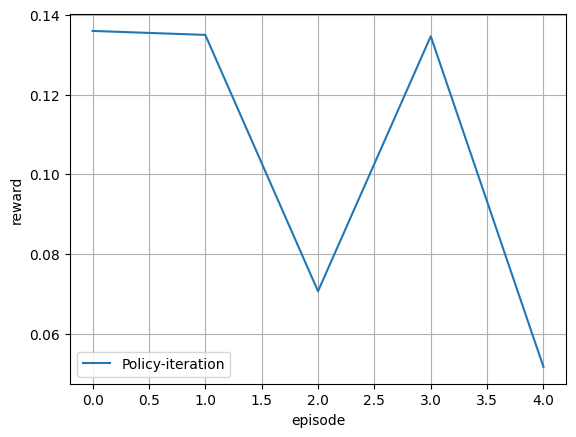

In [ ]:
''' An example of solving New Hold'em with policy iteration
'''
import os
import argparse

import rlcard
from rlcard.agents import (
    ThresholdAgent2, PIAgent
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = PIAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_pi_result/',
            'pi_model',
        ),
    )


    # Evaluate PI
    eval_env.set_agents([
        agent,
        ThresholdAgent2(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent2(num_actions=env.num_actions),
    ])


    # Start training
    with Logger('experiments/new_limit_holdem_pi_result/') as logger:
        # Evaluate the performance.
        agent.train()
        agent.save()
        for episode in range(5):
            logger.log_performance(
                episode,
                tournament(
                    eval_env,
                    3000
                )[0]
            )
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Policy-iteration')

if __name__ == '__main__':
    train()


⭕ **Results**

▶ At each iteration we print the total value earned for running the old policy for the sum of different games and also the changes in policy.   
▶ As we can see we win **0.05-0.15 chips** per game running our mdp model. It seems reasonable to have such a low chips won per game as the game rules as very simple and the rule based model can produce a good policy. However this doesnt seem to be the optimal policy but a sub-optimal one. Afterwards we will see that the Qlearning agents produce a policy that achieves better results.    
▶ A possible explanation of our policy not being optimal is that our algorithm takes the average policy between multiple possible card combinations that could come based on the probability of getting those cards. However different card combination could result of huge differences in the policy and getting the average of them could be a non optimal solution.

### Play against Policy Iteration Agent

---


Here is an example of playing against the Agent.    
❗ The model saved is the model of the last above example you run. For example if you run the example vs the Threshold Agent2 last the agent is trained to beat this agent. This is the agent we recomment playing against as it has the more 'human' like decision making. If no example played the agent will have no model.

In [ ]:
import os

#import args as args

import rlcard
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.agents import PIAgent
from rlcard.utils.utils import print_card

# Make environment
env = rlcard.make('new-limit-holdem')
human_agent = HumanAgent(env.num_actions)
# Init agent:
pi_agent = PIAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_pi_result/pi_model',
        ),
)
pi_agent.load()

# hard code the agen you want to play against (pi_agent, ql_agent, sarsa_agent)
env.set_agents([
    human_agent,
    pi_agent,
])



print(">>New Limit Hold'em random agent")

while (True):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action

    if len(trajectories[0]) != 0:
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            """
            if action_record[-i][0] == state['current_player']:
                break
            """
            _action_list.insert(0, action_record[-i])
        for pair in _action_list:
            print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('=============     Random Agent    ============')
    print_card(env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    # print(trajectories[0])
    # print("=========================================================================================================")
    # print(trajectories[1])
    input("Press any key to continue...")

>>New Limit Hold'em random agent
>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐
│Q        │
│         │
│         │
│    ♣    │
│         │
│         │
│        Q│
└─────────┘
===============     Chips      ===============
Yours:   +
++
=========== Actions You Can Choose ===========
0: raise, 1: check

>> You choose action (integer): 1
>> Player 0 chooses check
>> Player 1 chooses raise

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐
│Q        │
│         │
│         │
│    ♣    │
│         │
│         │
│        Q│
└─────────┘
===============     Chips      ===============
Yours:   +
+++
=========== Actions You Can Choose ===========
0: call, 1: fold

>> You choose action (integer): 0
>> Player 0 chooses check
>> Player 1 chooses raise
>> Player 0 chooses call
>> Player 1 chooses check

=============== Community Card =============

KeyboardInterrupt: ignored

### 🟩 **Total conclusions**

---
▶ Our agent converges in 4 iterations and less than 2 minutes which is reasonable.    
▶ The policy found is optimal of the random agent which is not making card based decisions but not for the rule based models. This is probably because the card based decisions the agents make produce big differences in policy for every different combination. Taking the average of those doesnt seem to be the optimal solution. Another possible explanation is that the way our algorithm works is that it runs games with multiple card combinations and all possible actions of agents, in a game however we could encounter the same state twice. For example this action sequences: a1:raise a2:call and a1:check a2:raise a1: call a2:check, those action sequences bring as to the same state. This could mean that some states are 'explored' better than others or that our state space is not good enough.

# **Value Iteration**

We also tried a different approach to implement value iteration algorithm.  
The concept is to learn the enviroment by playing many games trying each possible move at every step.

Full code can be found in

▶ rlcard/agents/value_iteration_agent.py  
▶ rlcard/examples/run_value_iter.py

### **Overview**

### <u>Step 1</u>


In each round we update the reward of the terminal states and the probabilities of reaching each state.
After many rounds, of playing we can get an adequate estimation of the rewards and probabilities of each state.

However, these quantities are not fixed as the both the cards played and the opponent's behaviour is probabilistic.  

### <u>Step 2</u>
Run value iteration algorithm until it converges.

### <u>Step 3</u>
Evaluate agent by playing against different kind of opponents.


### **Description**

The state space is constructed like the frozenlake enviroment:  
▶ Each state has one or more legal actions, which lead to one or more other state with corresponding probabilities and rewards.

▶ Information about number of times an action is taken and a state has been reached is held. These are necessary to dynamicaly update the state space values, as the agents plays games to learn the enviroment.

▶ The value of reward of each terminal state is calculated as the sum of the former reward plus the current divided by two, in order to smooth extreme fluctuations in payoffs.

Below is a code snippet of the main part of *traverse_tree()* function used for enviroment exploration.  
You have to keep in mind that:  
◼ The state space has information coming only from the agent perspective(i.e. information about opponent's cards are unknown).  
◼ Every time the agent reaches a state, the state space needs updating.
```
  if current_player == self.agent_id:
            obs, legal_actions = self.get_state(current_player)
            # update state space
            self.update_P(obs, legal_actions)
            for action in legal_actions:
                # Keep traversing the child state
                self.env.step(action)
                q, next_state, terminal = self.traverse_tree()    # I want my next state, not opponent's state
                if terminal:                    # If next state is terminal we should update P
                    if next_state == "other player":
                        # this is my last state, game is finished and i took last action e.g. fold
                        next_state, next_st_legal_actions = self.get_state(current_player)  # this way we pass in next state the info about action taken
                        self.update_P(next_state, next_st_legal_actions)    # to record the last state into dicts
                    else:
                        self.update_P(next_state, legal_actions)    # to record the last state into dicts
                    
                    # iterate in P to set reward of next state
                    # a state must give same reward in value iteration whenever it shows up
                    # for state in self.P:
                    #     for act in state:
                    for state in self.P:
                        for act in self.P[state]:
                            if next_state in self.P[state][act][0].keys():
                                self.P[state][act][0][next_state][1] = (self.P[state][act][0][next_state][1] + q) / 2     # q_new = (q_old + q) / 2

                self.env.step_back()
```



🟢**value_iteration_algo()**

This function calculates the optimal policy for the enviroment.  
gamma parameter has been set to 0.01 because experiments conducted showed that smaller gamma leads to


1.   Better performance
2.   Faster convergence

For playing against threshold agent 2 setting g = 0.99 resulted in 2401 iterations to converge, whereas setting g = 0.01 resulted in 6 iterations to converge.

Better performance is achieved because in our enviroment only few steps are required to get the payoffs. Thus, setting g closer to zero, makes the agent pursuing immediate rewards, which in our case is preferred.

```
 def value_iteration_algo(self):
        iteration = 0
        for state in self.P:
                self.V[state] = [0,0]
        while True:
            for state in self.P:
                self.Q[state] = [0,0,0,0]
            for state in self.P:
                for action in self.P[state]:
                    for item in self.P[state][action][0].items(): # for every next state after current state obs taking certain action
                        prob_next_st, rew_next_st, ctr = item[1]    
                        nxt_st = item[0]
                        self.Q[state][action] += prob_next_st * (rew_next_st + self.gamma * self.V[nxt_st][0])
            ll = list(self.Q.values())  # list of lists with Q values of each action per state
            q_vals = np.max(ll, axis = 1)    #maximum expected reward for each state as calculated in Q table
            v_vals = [item[0] for item in list(self.V.values())]    # list of rewards in V
            if np.max(np.abs(np.subtract(q_vals,v_vals))) < self.conv_limit:
                # converged
                print('\nState space has {} different states'.format(len(self.V)))
                print('Value iteration converged after {} iterations'.format(iteration))
                break   # found convergence must stop
            # Since i have not converged, i set new V(s)
            q_vals_ind = np.argmax(ll, axis = 1)    # index of action which provides the maximum expected reward for each state as calculated in Q table
            for i, st in enumerate(self.Q):         # Setting V value for each state
                self.V[st][1] = q_vals_ind[i]       # action that provides maximum expected reward when at state st
                self.V[st][0] = q_vals[i]           # maximum expected reward when at state st
            iteration += 1
```




🟢**eval_step(state)**  
This function predicts the action given the current state for evaluation. When the state has been explored, the action which gives the highest expected V value will be taken, otherwise the action will be random.

🟢**get_state(player_id)**

This function returns the current state of the player given his id.
This information include his hand, public cards, all chips bet, player's chips, legal actions in that state and number of raises in that round (preflop, postflop)

## **Experiments**
Below experiments, of playing against various agents, are conducted.  
The agent plays 2000 games to learn the enviroment. After that value iteration algorithm is run until it converges and finally 2000 games are played for evaluation.

### Value iteration VS Random Agent

Learning the enviroment 1999
State space has 11033 different states
Value iteration converged after 11 iterations

----------------------------------------
  episode      |  0
  reward       |  0.5735
----------------------------------------

----------------------------------------
  episode      |  50
  reward       |  0.404
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  0.456
----------------------------------------

----------------------------------------
  episode      |  150
  reward       |  0.5195
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  0.4905
----------------------------------------

----------------------------------------
  episode      |  250
  reward       |  0.4675
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  0.389
-----------------------

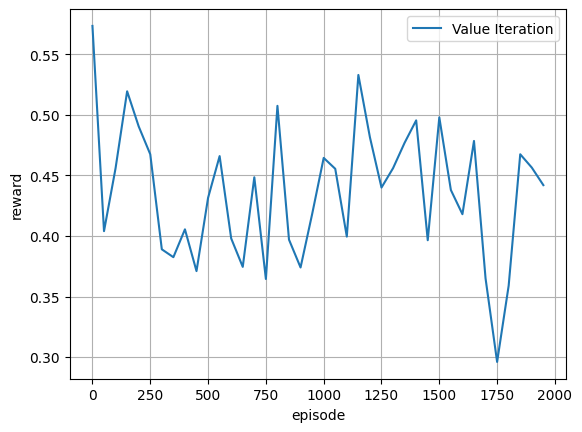

In [ ]:

import os
import argparse

import rlcard
from rlcard.agents import (
    ThresholdAgent,
    ThresholdAgent2,
    RandomAgent,
)

from rlcard.agents.value_iteration_agent import ValueIterAgent
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = ValueIterAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_vi_result/',
            'vi_model',

        ),
    )
    #agent.load()  # If we have saved model, we first load the model

    # Evaluate Value Iteration
    eval_env.set_agents([
        agent,
        # ThresholdAgent(num_actions=env.num_actions),
        RandomAgent(num_actions=env.num_actions)
        # ThresholdAgent2(num_actions=env.num_actions)
    ])

    env.set_agents([
        agent,
        # ThresholdAgent(num_actions=env.num_actions),
        RandomAgent(num_actions=env.num_actions)
        # ThresholdAgent2(num_actions=env.num_actions)
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_vi_result/') as logger:
        for episode in range(2000):
            print('\rLearning the enviroment {}'.format(episode), end='')
            agent.learn_env()

            # now begin training
        agent.value_iteration_algo()
        for episode in range(2000):
            if episode % 50 == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        2000
                    )[0]
                )
        # print('Random choices {}'.format(agent.random_choices))
        # print('Value choices {}'.format(agent.value_choices))
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Value Iteration')

if __name__ == '__main__':
    train()

### Value iteration VS Threshold Agent 2
---

Learning the enviroment 1999
State space has 11518 different states
Value iteration converged after 11 iterations

----------------------------------------
  episode      |  0
  reward       |  0.0225
----------------------------------------

----------------------------------------
  episode      |  50
  reward       |  -0.1465
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  -0.0615
----------------------------------------

----------------------------------------
  episode      |  150
  reward       |  -0.1645
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  -0.245
----------------------------------------

----------------------------------------
  episode      |  250
  reward       |  -0.138
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  -0.163
-----------------

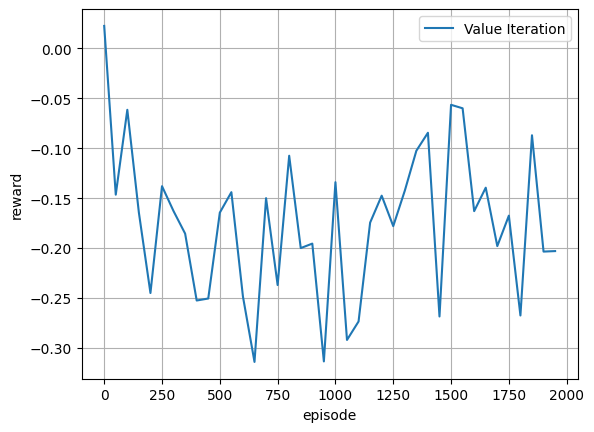

In [ ]:

import os
import argparse

import rlcard
from rlcard.agents import (
    ThresholdAgent,
    ThresholdAgent2,
    RandomAgent,
)

from rlcard.agents.value_iteration_agent import ValueIterAgent
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = ValueIterAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_vi_result/',
            'vi_model',

        ),
    )
    #agent.load()  # If we have saved model, we first load the model

    # Evaluate Value Iteration
    eval_env.set_agents([
        agent,
        # ThresholdAgent(num_actions=env.num_actions),
        # RandomAgent(num_actions=env.num_actions)
        ThresholdAgent2(num_actions=env.num_actions)
    ])

    env.set_agents([
        agent,
        # ThresholdAgent(num_actions=env.num_actions),
        # RandomAgent(num_actions=env.num_actions)
        ThresholdAgent2(num_actions=env.num_actions)
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_vi_result/') as logger:
        for episode in range(2000):
            print('\rLearning the enviroment {}'.format(episode), end='')
            agent.learn_env()

            # now begin training
        agent.value_iteration_algo()
        for episode in range(2000):
            if episode % 50 == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        2000
                    )[0]
                )
        # print('Random choices {}'.format(agent.random_choices))
        # print('Value choices {}'.format(agent.value_choices))
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Value Iteration')

if __name__ == '__main__':
    train()

###Value iteration VS Threshold Agent
---

Learning the enviroment 1999
State space has 16875 different states
Value iteration converged after 3 iterations

----------------------------------------
  episode      |  0
  reward       |  -0.183
----------------------------------------

----------------------------------------
  episode      |  50
  reward       |  -0.702
----------------------------------------

----------------------------------------
  episode      |  100
  reward       |  -0.598
----------------------------------------

----------------------------------------
  episode      |  150
  reward       |  -0.711
----------------------------------------

----------------------------------------
  episode      |  200
  reward       |  -0.725
----------------------------------------

----------------------------------------
  episode      |  250
  reward       |  -0.745
----------------------------------------

----------------------------------------
  episode      |  300
  reward       |  -0.7925
--------------------

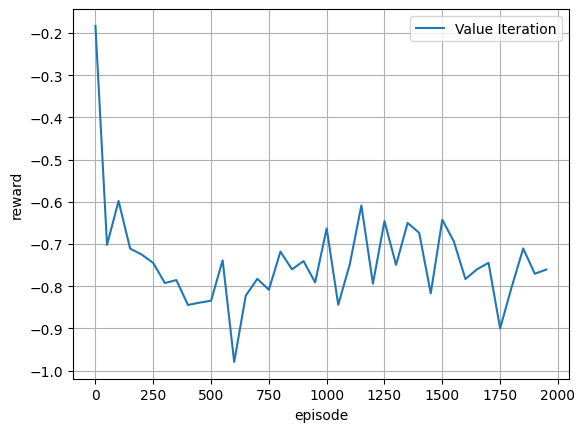

In [ ]:

import os
import argparse

import rlcard
from rlcard.agents import (
    ThresholdAgent,
    ThresholdAgent2,
    RandomAgent,
)

from rlcard.agents.value_iteration_agent import ValueIterAgent
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = ValueIterAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_vi_result/',
            'vi_model',

        ),
    )
    #agent.load()  # If we have saved model, we first load the model

    # Evaluate Value Iteration
    eval_env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
        # RandomAgent(num_actions=env.num_actions)
        # ThresholdAgent2(num_actions=env.num_actions)
    ])

    env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
        # RandomAgent(num_actions=env.num_actions)
        # ThresholdAgent2(num_actions=env.num_actions)
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_vi_result/') as logger:
        for episode in range(2000):
            print('\rLearning the enviroment {}'.format(episode), end='')
            agent.learn_env()

            # now begin training
        agent.value_iteration_algo()
        for episode in range(2000):
            if episode % 50 == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        2000
                    )[0]
                )
        # print('Random choices {}'.format(agent.random_choices))
        # print('Value choices {}'.format(agent.value_choices))
        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Value Iteration')

if __name__ == '__main__':
    train()

⭕ **Results**  
From the above experimets we make the following observations


*   Our agent has descent behaviour against Random Agent achieving mean reward per game ranging [0.3, 0,5]. Better reward could be achieved by playing more games during enviroment learning phase. However, this leads to increased amount of exploration time and computational force needed.
*   Our agent fails to perform well against Threshold Agent 2 achieving mean reward per game ranging [0, -0,3].
*   Our agent fails to perform well against Threshold Agent achieving mean reward per game ranging [0, -0,7].  


This performance is due to the fact that the enviroment is not completely explored and estimated, thus leading to suboptimal performance, as the agent plays randomly when an unknown state is reached.


# **Q-LEARNING**

## Brief description


---
🔵 To train our agent we run training simulation games vs an opponent.   
🔵 During the training games our agent makes every possible available action, then traverses the game tree and afterwards the Qvalue is computed(clasic dynamic programming).    
🔵 We update our policy:    
▶First we update our Qvalues:
\begin{align}
        Q(s,a)_{new} = Q(s,a)_{old} + α*(γ*Q(s',a')_{max}-Q(s,a)_{old})
    \end{align}
In our implementation as you can see from above we dont have immediate action rewards.  
▶ Then we turn this Q values to a policy using softmax.   
🔵 Then we return the max Qvalue of the state or a random one (e-greedy approach). This max Qvalue is used in the previous state to update the Qvalues.



## Detailed description

### A more detailed description of our algorithm
---    
🔵**Arguments**:    
▶**policy**: The dictionary where we store our policy, we use as key **obs[32]** array which was analyzed in the enviroment section, and the value is leads to is numpy array contain the probability of every action (eg [0 0.4 0 0.6]).   
▶**qualities**: Same dictionary as above but we store Qvalues instead of action probabilities.    
▶**iteration**: Storing the number of training games run.     
▶**agent_id**: This indicates the starting possition of our agent in a game.   
▶**alpha**: the learning rate, after multiple examples run (we created a script examples/tune_hparam and tune_haparam2) and we decided to use a low aplha hyperparameter: 0.1. Having this low alpha factor we have a slower convergence time but we do converge to the optimal policy. We will futhermore analyze that in the experiments section below.   
▶**gamma factor**: No immediate rewards so we used 1.   
▶**decay_factor**: Epsilon decay factor.    


```
# self.epsilon = 1
        self.gamma = g
        self.alpha = a
        self.decay_factor = e
        self.agent_id = 0
        self.use_raw = False
        self.env = env
        self.model_path = model_path
        self.epsilon_min = 0.01
        self.v = 0

        # A policy is a dict state_str -> action probabilities
        self.policy = collections.defaultdict(list)

        # Regret is a dict state_str -> action regrets
        self.qualities = collections.defaultdict(list)

        self.iteration = 0
```


🔵 **train()**:   
We run 1 training game and we decay epsilon.    
🔵 **traverse_tree()**:   
This is the method responsible for running the training game and updating the policy. It uses a clasic dynamic programming approach to traverse the game tree until the ending state when we get our reward/chips won or lost.    
**3 possible situations**:    
▶**End game**:    
 we reached the end of the game so we return the chips won/lost as reward.     


```
# if self.env.is_over():
            chips = self.env.get_payoffs()
            return chips[self.agent_id]
```


▶**Other agent turn**:    
 Other agent makes an action and we continue traversing the game tree.    


```
# if not current_player == self.agent_id:
            state = self.env.get_state(current_player)
            # other agent move
            action = self.env.agents[current_player].step(state)

            # Keep traversing the child state
            self.env.step(action)
            Vstate = self.traverse_tree()
            self.env.step_back()
            return Vstate * self.gamma
```
▶**Our agent turn**:       
For our agent we first take our current policy for this state with action_probs(more to follow). Then we take every action and store the Qvalue in the quality list. Then we update Qvalues and policy. Then we return the max Qvalue or a random Qvalue (depending on current e) to be used in the next state to update the Qvalues.



```
#if current_player == self.agent_id:
            quality = {}
            obs, legal_actions = self.get_state(current_player)
            # if first time we encounter state initialize qualities or get the previous policy
            self.action_probs(obs, legal_actions, self.policy, self.qualities)

            for action in legal_actions:
                # Keep traversing the child state
                self.env.step(action)
                q = self.traverse_tree()
                self.env.step_back()

                quality[action] = q  # value of each action

            ''' alter policy according to new Vactions'''
            if np.random.rand() < self.epsilon:
                # explore
                qstate = np.random.choice(list(quality.values()))
            else:
                # action with highest Q value
                qstate = np.max(list(quality.values()))

            ''' alter Qfunction according to Q_next_state'''
            self.update_policy(obs, quality, legal_actions)

        return qstate * self.gamma
```
🔵**action_probs()**:   
This method basicly initializes the Qvalues of the state (zeros) and the policy for all the new states found.


```
# def action_probs(self, obs, legal_actions, policy, action_values):
      if obs not in policy.keys() and obs not in self.qualities.keys():
                  tactions = np.array([-np.inf for action in range(self.env.num_actions)])
                  for action in range(self.env.num_actions):
                      if action in legal_actions:
                          tactions[action] = 0
                  self.qualities[obs] = tactions
                  action_probs = softmax(tactions)
                  self.policy[obs] = action_probs
              else:
                  action_probs = policy[obs].copy()
              action_probs = remove_illegal(action_probs, legal_actions)
              return action_probs
```


🔵**update_policy()**:    
This method updates the Qvalues of the state and then computes a policy using softmax on the Qvalues:   
\begin{align}
        Q(s,a)_{new} = Q(s,a)_{old} + α*(γ*Q(s',a')_{max}-Q(s,a)_{old})
    \end{align}   
In our implementation as you can see from above we dont have immediate action rewards.  


```
# def update_policy(self, obs, next_state_values, legal_actions):
        # update the quality function
        qf = self.qualities[obs]
        for i in next_state_values:
            qf[i] += self.alpha * (next_state_values[i] - qf[i])

        # update action values
        self.qualities[obs] = qf
        self.policy[obs] = softmax(qf)
```
All the code parts listed above can be found in **rlcard/agents/ql_agent** with detailed commenting.







## Experiments

---



### Q-Learning vs Random Agent
a = 0.1


---
▶ We train our agent against Random agent. We have a total number of episodes=6000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.1 (an example with higher learning rate will follow just to compare).    



Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.7423333333333333
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  0.74
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  0.77
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  0.7456666666666667
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.7896666666666666
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.7216666666666667
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       |  0.792
-

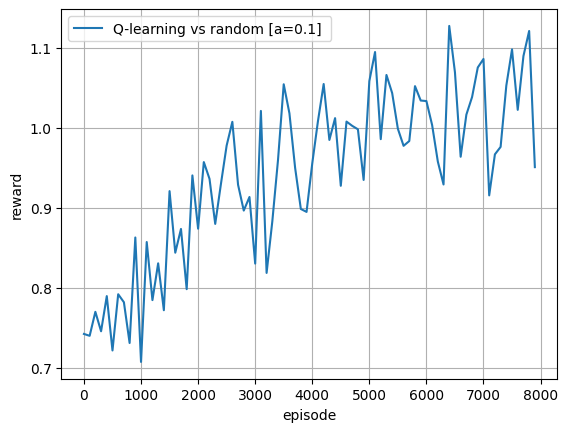

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/',
            'ql_model_random_a=0.1',
        ),
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(8000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning vs random [a=0.1] ')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_ql_result/ql_model_random_a=0.1

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **1 - 1.1 chips** per game after converging to the optimal policy.     
▪ We converge after **5000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ It is clear that our agent does learn during the training and converges to an optimal/suboptimal policy.     
▪ Converging time is slow due to the low alpha factor but we have a low overshoot and a generally stable learning progression.    
◾ We seem to be stuck in a suboptimal policy, which however is very close to the optimal one found in the *mdp section* and was winning 1.1-1.2 chips per round.

### Q-Learning vs Random Agent
a = 0.5


---

▶ We train our agent against Random agent. We have a total number of episodes=6000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.5 (just to compare with the a=0.1).    

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.7423333333333333
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  0.6416666666666667
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  0.725
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  0.8386666666666667
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.701
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.6393333333333333
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       |  0.793

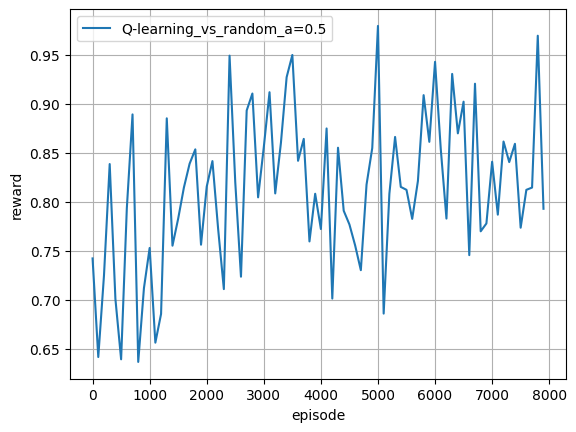

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/',
            'ql_model_random_a=0.5',
        ),
        0.5,
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(8000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning vs random [a=0.5]')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_ql_result/ql_model_random_a=0.5

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **0.75 - 0.95 chips** per game after converging to the optimal policy.     
▪ We converge after **2000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ As expected we converge much faster to the optimal/suboptimal policy.   
▪ It is clear that this is not the optimal policy but a much worst one.   
▪ Very high overshoot, generally unstable learning progression.   
▪ For sure a=0.5 is not a good option we must go lower to produce better and more stable results.

### Q-Learning vs Threshold Agent
a = 0.1
e_decay = 0.99

---


▶ We train our agent against Threshold agent. We have a total number of episodes=6000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.1 (as it produces a stable result).    
▶ We use epsilon decay = 0.99 (next we will experiment using a higher one)

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.16466666666666666
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  -0.034666666666666665
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  -0.030666666666666665
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  -0.024
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.021333333333333333
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  -0.052333333333333336
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  6

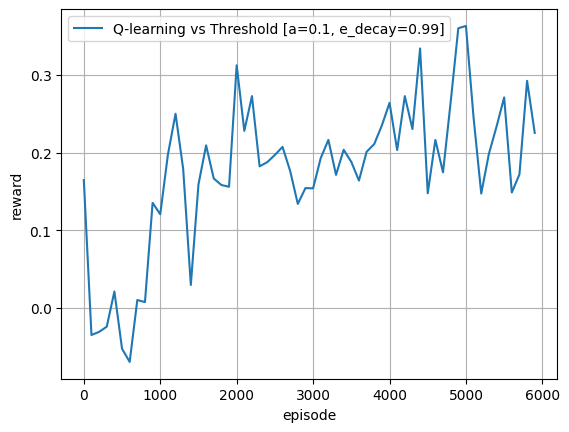

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/',
            'ql_model_threshold_epsilon=0.99',
        ),
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(6000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning vs Threshold [a=0.1, e_decay=0.99]')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_ql_result/ql_model_threshold_epsilon=0.99

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **0.2 - 0.35 chips** per game after converging to the optimal policy.     
▪ We converge after **2000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ It is clear that our agent does learn during the training and converges to an optimal/suboptimal policy.     
▪ Converging time is faster than the random agent, this is expected as the threshold agent has a certain move set.    
▪ Maybe our agent doesnt explore enough and a higher epsilon decay could help(we will see in the next experiment).    
▪ The results could be the ones of an optimal policy, they are higher than the mdp agent and seems reasonable as the game rules are very simple and rule based model can be very effective. Having a bad card our agent cannot win and it only can minimize its loss.

### Q-Learning vs Threshold Agent
a = 0.1
e_decay = 0.995

---
▶ We train our agent against Threshold agent. We have a total number of episodes=6000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.1 (as it produces a stable result).    
▶ This time we experiment with a higher epsilon decay = 0.995

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.16466666666666666
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  -0.08433333333333333
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  -0.034
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  -0.08
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  -0.03966666666666667
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  -0.073
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       |  -0.121
----

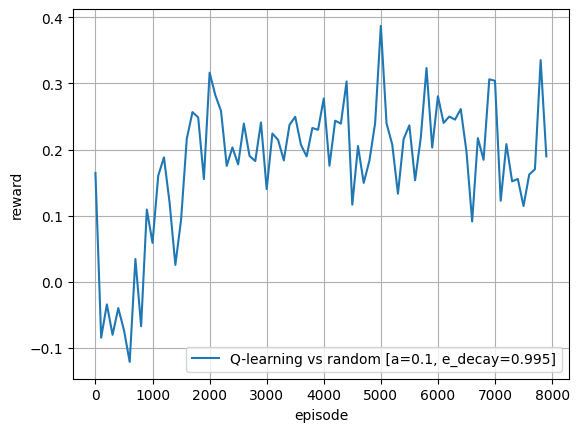

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/',
            'ql_model_threshold_epsilon=0.995',
        ),
        0.1,
        1,
        0.995
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(6000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning vs Threshold [a=0.1, e_decay=0.995]')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_ql_result/ql_model_threshold_epsilon=0.995

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **0.2 - 0.35 chips** per game after converging to the optimal policy.     
▪ We converge after **2000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ In comparison with the previous epsilon decay = 0.99 we seem to have small differences such as a less overshoot.

### Q-Learning vs Threshold Agent2
a = 0.1
e_decay = 0.99

---
▶ We train our agent against Threshold agent2. We have a total number of episodes=6000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.1 (as it produces a stable result).    
▶ epsilon decay = 0.99

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.109
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  -0.168
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  0.043333333333333335
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  0.08733333333333333
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.126
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.06233333333333333
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       |  0.05333333333

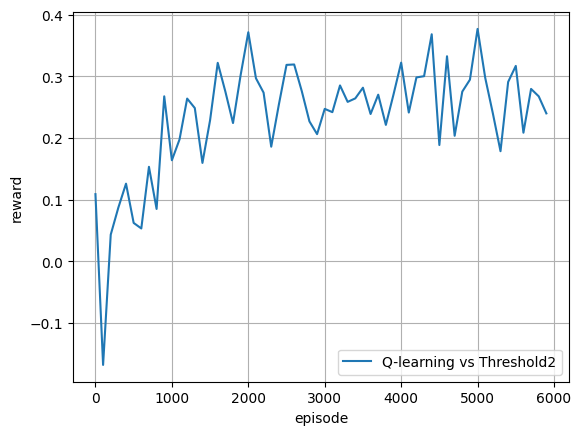

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/',
            'ql_model_threshold2',
        ),
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        ThresholdAgent2(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent2(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(6000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning vs Threshold2')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_ql_result/ql_model_threshold2

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **0.2 - 0.4 chips** per game after converging to the optimal policy.     
▪ We converge after **1000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ Faster convergence than the threshold agent, thats is expected because threshold agent2 makes less probabilistic moves and follows a stricter policy.     
▪ It is clear that our agent does learn during the training and converges to an optimal/suboptimal policy.    
▪ Maybe our agent doesnt explore enough and a higher epsilon decay could help(we will see in the next experiment).    
▪ The results could be the ones of an optimal policy, they are higher than the mdp agent and seems reasonable as the game rules are very simple and rule based model can be very effective. Having a bad card our agent cannot win and it only can minimize its loss.

### Play against Q-learning agent


---
Here is an example of playing against the Agent.    
❗ To run this example you have to run the Q-learning vs Threshold Agent2 above. This is the agent we recomment playing against as it has the more 'human' like decision making. There is not model saved in the project before running the examples.

In [ ]:
import os

#import args as args

import rlcard
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.agents import PIAgent
from rlcard.utils.utils import print_card

# Make environment
env = rlcard.make('new-limit-holdem')
human_agent = HumanAgent(env.num_actions)
# Init agent:
ql_agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_ql_result/ql_model_threshold2',
        ),
    )
ql_agent.load()

# hard code the agen you want to play against (pi_agent, ql_agent, sarsa_agent)
env.set_agents([
    human_agent,
    ql_agent,
])



print(">>New Limit Hold'em random agent")

while (True):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action

    if len(trajectories[0]) != 0:
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            """
            if action_record[-i][0] == state['current_player']:
                break
            """
            _action_list.insert(0, action_record[-i])
        for pair in _action_list:
            print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('=============     Random Agent    ============')
    print_card(env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    # print(trajectories[0])
    # print("=========================================================================================================")
    # print(trajectories[1])
    input("Press any key to continue...")

>>New Limit Hold'em random agent
>> Start a new game

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐
│Q        │
│         │
│         │
│    ♣    │
│         │
│         │
│        Q│
└─────────┘
===============     Chips      ===============
Yours:   +
++
=========== Actions You Can Choose ===========
0: raise, 1: check

>> You choose action (integer): 0
>> Player 0 chooses raise
>> Player 1 chooses call

=============== Community Card ===============
┌─────────┐   ┌─────────┐
│J        │   │K        │
│         │   │         │
│         │   │         │
│    ♦    │   │    ♣    │
│         │   │         │
│         │   │         │
│        J│   │        K│
└─────────┘   └─────────┘
===============   Your Hand    ===============
┌─────────┐
│Q        │
│         │
│         │
│    ♣    │
│         │
│         │
│        Q│
└─────────┘
===============     Chips      ===============
Yours:   ++
++++
=========== Actions Y

KeyboardInterrupt: ignored

### 🟦 **Total conclusions**

---
▶ Our agent's convergence speed varies and depends on the type of the opponent. Versus probabilistic opponents the agent needs more time to figure the best policy and doesnt converge to the optimal one.    
▶ Versus the rule based models the agent has much better behavior as it converges faster and produces a policy better than the MDP.   
▶ A low learning rate is more appropriate for our enviroment as it guarantees a convergence to the optimal policy and more stable performance.    
▶ Generally we may say that the behavior of our agent is what we expected for the specific algorithm. We reach an optimal policy in a reasonable time.

# **SARSA**

## Brief description


---
🔵 We also made a Sarsa agent to compare with the Q-learning.   
🔵 We wont analyze the agent/algorithm as it is almost the same with the Q-learning one. Instead we will note the differences and procceed to the experiments section.    
🔵 Differences:   
The only difference is in the way we update the Qvalues:    
▶We have an **on policy** approach now:
\begin{align}
        Q(s,a)_{new} = Q(s,a)_{old} + α*(γ*Q(s',a')-Q(s,a)_{old})
    \end{align}
In our implementation as you can see from above we dont have immediate action rewards. Furthermore instead of the greedy q-learning approach where we have the max Qvalue, we use:
\begin{align}
        Q(s',a') = \sum_{s'}prob(s,a,s')V(s').
    \end{align}
▶ So we compute the State Value and we return it to the previous step, then the Stave Value is used as the Qvalue of an action.   


```
if current_player == self.agent_id:
            quality = {}
            value = 0
            obs, legal_actions = self.get_state(current_player)
            action_probs = self.action_probs(obs, legal_actions, self.policy, self.qualities)
            for action in legal_actions:
                action_prob = action_probs[action]

                # Keep traversing the child state
                self.env.step(action)
                q = self.traverse_tree()
                self.env.step_back()

                value += action_prob * q
                quality[action] = q  # value of each action

            ''' alter policy according to new Vactions'''
            self.update_policy(obs, quality, legal_actions)

        return value*self.gamma
```

All the code parts listed above can be found in **rlcard/agents/sarsa_agent** with detailed commenting.


## Experiments

---



### SARSA vs Random agent
a=0.3



---
▶ We train our agent against Random agent. We have a total number of episodes=8000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.  
▶ We use a low learning rate = 0.3.


Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.7423333333333333
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  1.0333333333333334
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  0.916
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  0.8856666666666667
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.869
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.7723333333333333
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       |  0.705

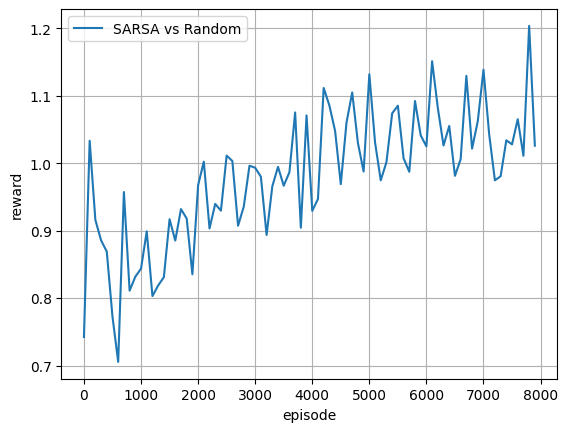

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = SARSAAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_sarsa_result/',
            'sarsa_model_random',
        ),
        0.3,
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(8000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'SARSA vs Random')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_sarsa_result/sarsa_model_random

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **1 - 1.2 chips** per game after converging to the optimal policy.     
▪ We converge after **4000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ It is clear that our agent does learn during the training and converges to an optimal/suboptimal policy.     
▪ Converging time is slow due to the low alpha factor but we have a low overshoot and a generally stable learning progression.    
◾ We seem to have a faster convergence that the q-learning but not a big difference, reward almost the same. Where we see a big difference is the overshoot of our plot. Our policy is more stable.

### SARSA vs Threshold agent
a=0.3



---
▶ We train our agent against Random agent. We have a total number of episodes=8000 and we evaluate every 100 training iterations running 3000 evaluation games getting the average reward per game as a result.   
▶ We use a low learning rate = 0.3.


Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.16466666666666666
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  100
  reward       |  0.043333333333333335
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  200
  reward       |  -0.08766666666666667
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  300
  reward       |  -0.028
----------------------------------------
Iteration 400
----------------------------------------
  episode      |  400
  reward       |  0.026
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  -0.11366666666666667
----------------------------------------
Iteration 600
----------------------------------------
  episode      |  600
  reward       

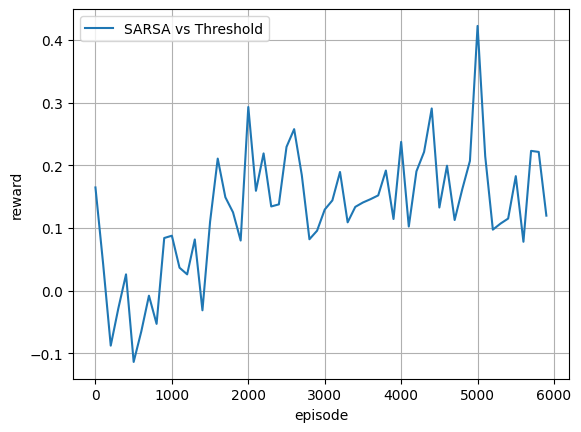

In [ ]:
import os

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = SARSAAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem_sarsa_result/',
            'sarsa_model_threshold',
        ),
        0.3,
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem_ql_result/') as logger:
        for episode in range(6000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 100 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'SARSA vs Threshold')

if __name__ == '__main__':
    train()

Run this if you want to delete the model and retrain.   
❗ No model is stored when the project is loaded.

In [ ]:
!rm -rf /content/experiments/new_limit_holdem_sarsa_result/sarsa_model_threshold

⭕ **Results**

---



▶ Ploting:    
▪ x-axis: number of episodes run.   
▪ y-axis: chips won per game during evaluation.    
▶ Observations:   
▪ As we can see we win **0.1 - 0.25 chips** per game after converging to the optimal policy.     
▪ We converge after **2000 training episodes**.     
▪ Sublinear reward.    
▶ Conclusions:    
▪ It is clear that our agent does learn during the training and converges to an optimal/suboptimal policy.     
▪ Converging time is slow due to the low alpha factor but we have a low overshoot and a generally stable learning progression.    
◾ We seem to same convergence speed but the reward is lower.

### 🟦 **Total conclusions**

---
▶ Compared to the Q-learning agent, SARSA seems to behave better vs the Random agent and worst vs rule based models. We expected such behavior from SARSA as it is a model that performs better in stochastic enviroments but may have limited exploration and converge in a suboptimal policy. In our experiments SARSA performed better vs Random as it its a more stochastic opponent and converged to a suboptimal policy versus the rule based modeled due it its limited exploration.

# **Extended Deck Experiments**

---



To run some experiments regarding the convergence time of the Q learning agent with created the **new-limit-holdem2**. We want to reach the limits of our agent and test it until the convergence get too slow and so we test with a **full 52 deck**. We also created a third Threshold model more appropriate for the new game. **Threshold agent3** raises on Q, K, A in the first round and later on raises on every pair and three combinations.

## Q-Learning vs Random

---
We run again the experiment, but now with the full deck.
We run 30000 training episodes, and we evaluate every 500 running 3000 evaluation games.


Iteration 0
----------------------------------------
  episode      |  0
  reward       |  0.7696666666666667
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.7456666666666667
----------------------------------------
Iteration 1000
----------------------------------------
  episode      |  1000
  reward       |  0.7043333333333334
----------------------------------------
Iteration 1500
----------------------------------------
  episode      |  1500
  reward       |  0.7483333333333333
----------------------------------------
Iteration 2000
----------------------------------------
  episode      |  2000
  reward       |  0.7616666666666667
----------------------------------------
Iteration 2500
----------------------------------------
  episode      |  2500
  reward       |  0.7893333333333333
----------------------------------------
Iteration 3000
----------------------------------------
  episode 

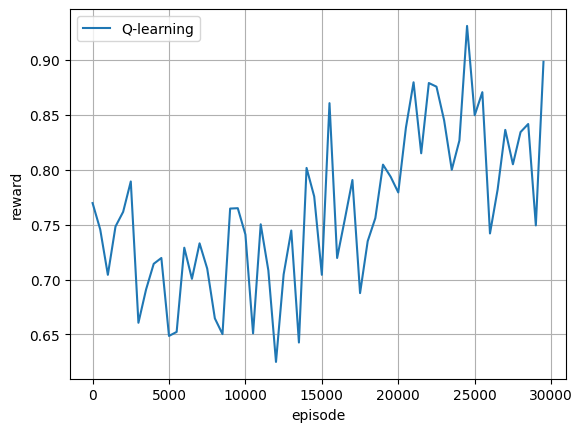

In [ ]:
import os
import argparse

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2, ThresholdAgent3
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem2',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem2',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem2_ql_result/',
            'ql_model_vs_random',
        ),
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        RandomAgent(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem2_ql_result/') as logger:
        for episode in range(30000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 500 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning')

if __name__ == '__main__':
    train()


In [ ]:
!rm -rf /content/experiments/new_limit_holdem2_ql_result/ql_model_vs_random

## Q-Learning vs Threshold3

---
We run again the experiment, but now with the full deck.
We run 10000 training episodes, and we evaluate every 250 running 3000 evaluation games.

Iteration 0
----------------------------------------
  episode      |  0
  reward       |  -0.10066666666666667
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  250
  reward       |  0.23033333333333333
----------------------------------------
Iteration 500
----------------------------------------
  episode      |  500
  reward       |  0.14866666666666667
----------------------------------------
Iteration 750
----------------------------------------
  episode      |  750
  reward       |  0.2956666666666667
----------------------------------------
Iteration 1000
----------------------------------------
  episode      |  1000
  reward       |  0.279
----------------------------------------
Iteration 1250
----------------------------------------
  episode      |  1250
  reward       |  0.252
----------------------------------------
Iteration 1500
----------------------------------------
  episode      |  1500
  reward     

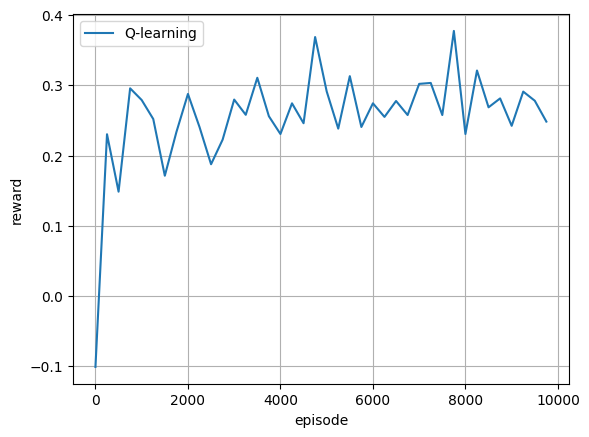

In [ ]:
import os
import argparse

import rlcard
from rlcard.agents import (
    QLAgent, SARSAAgent,
    RandomAgent, ThresholdAgent, ThresholdAgent2, ThresholdAgent3
)
from rlcard.utils import (
    set_seed,
    tournament,
    Logger,
    plot_curve,
)


def train():
    # Make environments
    env = rlcard.make(
        'new-limit-holdem2',
        config={
            'seed': 0,
            'allow_step_back': True,
        }
    )
    eval_env = rlcard.make(
        'new-limit-holdem2',
        config={
            'seed': 0,
        }
    )

    # Seed numpy, torch, random
    set_seed(42)

    # Initilize training Agent
    agent = QLAgent(
        env,
        os.path.join(
            'experiments/new_limit_holdem2_ql_result/',
            'ql_model_vs_Threshold',
        ),
    )
    agent.load()  # If we have saved model, we first load the model

    # Evaluate Ql
    eval_env.set_agents([
        agent,
        ThresholdAgent3(num_actions=env.num_actions),
    ])

    env.set_agents([
        agent,
        ThresholdAgent3(num_actions=env.num_actions),
    ])

    # Start training
    with Logger('experiments/new_limit_holdem2_ql_result/') as logger:
        for episode in range(10000):
            print('\rIteration {}'.format(episode), end='')
            # Evaluate the performance. Play with Random agents.
            if episode % 250 == 0:
                agent.save()  # Save model
                logger.log_performance(
                    episode,
                    tournament(
                        eval_env,
                        3000
                    )[0]
                )
                # print(agent.epsilon)
                #print(agent.v)
            agent.train()


        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path
    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'Q-learning')

if __name__ == '__main__':
    train()

### 🟦 **Total conclusions**

---
▶ **VS random**: as we can see the convergence speed gets much slower as it **doesnt even converge** in **30000 episodes**.   

▶ **VS Threshold3**: as we can see the convergence speed doesnt increase as much as the random opponent. It converges in **1500 episodes**. However this seems to be a policy good enough to beat the opponent and not the optimal one.     
 Our agent seems to be strangling against the more stochastic random agent but against the rule based model it learn the optimal policy almost as fast as before.